In [3]:
import json
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import display

In [4]:

def read_jsonl(jsonl_path) -> list:
    conversations = []
    with open(jsonl_path, "r", encoding="utf-8") as jsonl_file:
        for conversation in jsonl_file:
            first_msg = json.loads(conversation)["conversations"][0]["value"]
            data = {"message": first_msg}
            conversations.append(data)
    return conversations

In [6]:
# See README to get files
msgs_10k = read_jsonl(Path("../data/chatalpaca-10k.json"))
msgs_20k = read_jsonl(Path("../data/chatalpaca-20k.json")) 
msgs_puf = read_jsonl(Path("../data/Puffin.jsonl"))

In [7]:
def process_msgs(msgs):
    df = pd.DataFrame(msgs)
    df["len"] = df["message"].apply(lambda x: len(x))
    return df

In [8]:
df10 = process_msgs(msgs_10k)
df20 = process_msgs(msgs_20k)
dfpuf = process_msgs(msgs_puf)

In [9]:
def analyze_df(df, title="df"):
    print(title)
    df["len"].hist(); plt.show()
    display(df["len"].agg(["mean", "max", "median"]))

    # Number of 'long' prompts
    n_long = (df["len"] > 200).sum() 
    print(f"{n_long} 'long' prompts ({n_long / df.shape[0] * 100:0.2f}%)")

10k


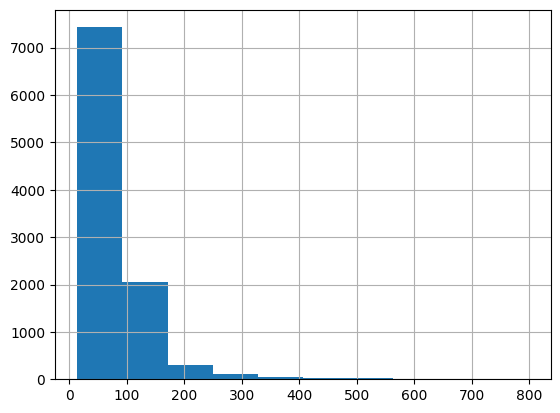

mean       82.4115
max       798.0000
median     67.0000
Name: len, dtype: float64

343 'long' prompts (3.43%)
puffin


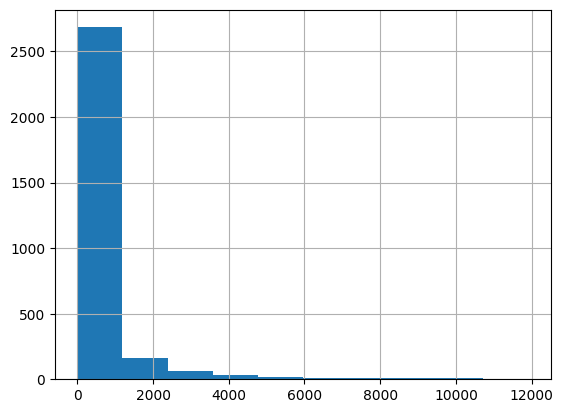

mean        570.403
max       11911.000
median      190.500
Name: len, dtype: float64

1437 'long' prompts (47.90%)
dftpuf


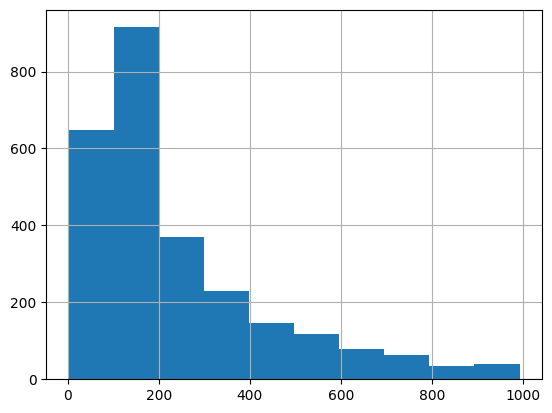

mean      241.27803
max       993.00000
median    167.00000
Name: len, dtype: float64

1077 'long' prompts (40.80%)


In [58]:
analyze_df(df10, "10k")
analyze_df(df20, "20k")
analyze_df(dfpuf, "puffin")
dftpuf = dfpuf[dfpuf["len"] < 1000]  # Cut so that it's not too expensive
analyze_df(dftpuf, "dftpuf")

Both dataset have approximately the same distribution. 

We should merge them and augment them with Puffin.jsonl.

In [10]:
# So construct dataset of 2640 puffins (not too long) + 4465 'long' (> 100tokens) from chatalpaca20k and 2895 randomly taken from chatalpaca with < 100 tokens
df = dftpuf.copy()
df = pd.concat([df, df20[df20["len"] >= 100]])
sampled = df20[df20["len"] < 100].sample(300)
df = pd.concat([df, sampled])
df

,message,len
19199,Name a type of facial recognition software.,43
13069,Generate a name for a new dress brand based on...,94
6283,What two birds are commonly seen in the Austra...,58
9647,Correct the surface level errors in the text: ...,94
15237,How could living in a big city affect a person...,54
...,...,...
6462,"Form a sentence using the phrase, ""in the curr...",59
2908,Write an algorithm to reverse a string.,39
4007,Identify the type of sentence in this phrase: ...,69
5821,Write a short paragraph about time management.,46


df


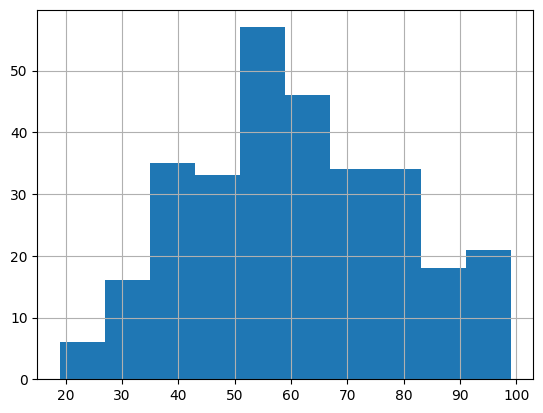

mean      60.346667
max       99.000000
median    59.000000
Name: len, dtype: float64

0 'long' prompts (0.00%)


In [11]:
analyze_df(df)

In [12]:
# Output in jsonl
dataset_jsonl = df.drop("len", axis=1).to_json(orient="records", lines=True)

In [13]:
with open("../data/dataset.jsonl", "a", encoding="utf-8") as f:
    f.writelines(dataset_jsonl )